[@lmaedler](https://www.uni-bremen.de/mvt/team/prof-dr-ing-habil-lutz-maedler) Jan. 9th 2020

# Particle Transport in a tube (convection and diffusion)

Let's begin by importing some python libraries we need for this notebook:

In [13]:
from IPython.display import Image
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

Let's consider a laminar flow in a circular tube without rotation. Particles are homogeneously introduced at the entrance across the radius. If a particles hits the wall, it is lost from the flow. The convective transport in x-direction is much larger than the transport by diffusion in this direction *(Pe >> 1)*. 

We will calculate the radial concentration profile alonge the tube and the remaining particle flux along the tube. We will compare our numerical solution with an existing analytical solution. 

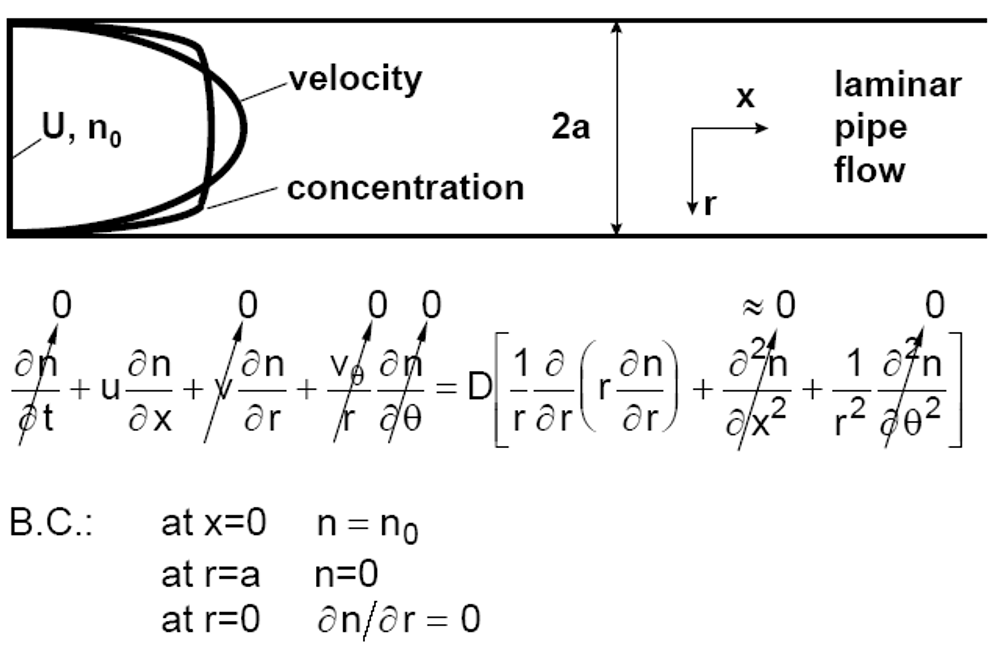

In [14]:
# Load image from local storage
Image(filename = "tube_problem_equations.png", width = 400)

We can make this equation non-dimensional using the following variables (with R = a):

$u_1 = \frac{u}{U_0}$,    $r_1 = \frac{r}{R}$,  $n_1 = \frac{n}{n_0}$,   $x_1 = \frac{x/R}{2RU/D}=\frac{x/R}{Pe}$

This leads to 

$$
\begin{split}
& \frac{u_1}{2}\cdot\frac{\partial n_1}{\partial x} =
\frac{1}{r_1}\cdot\frac{\partial}{\partial r_1}
\left(
r_1 \frac{\partial n_1}{\partial r_1}
\right)
\end{split}
$$

Using the product rule we obtain

$$
\begin{split}
& \frac{u_1}{2}\cdot\frac{\partial n_1}{\partial x} =
\frac{\partial^2 n_1}{\partial r_1^2} + 
\frac{1}{r_1}\cdot\frac{\partial n_1}{\partial r_1}
\end{split}
$$

with the follwing boundary conditions:

starting condition: $$n_1 = 0, \; \forall x_1, r_1$$

condition at the entrance: $$n_1 = 1 \; @ x_1 = 0, \; \forall r_1$$

condition at the wall: $$n_1 = 0 \; @ r_1 = 1, \; \forall x_1$$

symmetry condition in the middle of the tube: $$\frac{\partial n_1}{\partial r_1} = 0 \; @ r_1 = 0, \; \forall x_1$$

In [15]:
# variable declarations
nx = 5001
nr = 41
xmin = 0
xmax = 1
rmin = 0
rmax = 1
dx = (xmax - xmin) / (nx - 1)
dr = (rmax - rmin) / (nr - 1)

In [16]:
# Initialization
N = np.zeros((nx, nr))
u = np.zeros((nr))
A = np.zeros((nr, nr))
b = np.zeros((nr))
F = np.zeros((nr))
G = np.zeros((nr))
x = np.linspace(xmin, xmax, nx)
r = np.linspace(rmin, rmax, nr)
R1, X1 = np.meshgrid(r, x)

$u_1 = f(r)$ is our parabolic velocity profile for the laminar flow in a tube

$$
u_1 = 1 - r_1^2 \tag{1}
$$

### Discretized equations using Backward Euler scheme

Backward Euler in $x$ ($i$-discretization) and central in $r$ ($j$-discretization)


$$
\begin{split}
& \frac{u_1}{2}\left(\frac{n_{i,j}-n_{i-1,j}}{\Delta x} \right) =
\frac{n_{i,j+1}-2 n_{i,j}+n_{i,j-1}}{\Delta r^2} +
\frac{1}{r}\left(\frac{n_{i,j+1}-n_{i,j-1}}{2 \Delta r}\right)
\end{split}
$$

Rearranging equation for $n_{i-1,j}$ results in:
$$
\begin{split}
& n_{i-1,j} = n_{i,j+1}(-F_{j+1}-G_{j+1}) + n_{i,j}(1+2F_j) + n_{i,j-1}(-F_{j-1}+G_{j-1})
\end{split} 
\label{eq2}\tag{2}
$$
with
$$
F_j = \frac{\Delta x}{\Delta r^2} \frac{2}{u_{1,j}},
$$

$$
G_j = \frac{\Delta x}{r\cdot2\cdot\Delta r} \frac{2}{u_{1,j}}
$$
and
$$
u_{1,j} = 1 - (j\cdot \Delta r)^2
$$

In [17]:
for i in range(1, (nr-1), 1):
    u[i] = 1-(i*dr)**2                            # Parabolic velocity profile
    F[i] = dx / (dr**2) * 2/u[i]
    G[i] = dx / ((rmax - rmin) * 2 * dr) * 2/u[i]

Since we know $n_{0,j} = 1$ from our starting condion, the left hand side term $n_{i-1,j}$ is always know if we go along the $x$-direction. 

Our right hand side term only contains of the unknown concentrations with respect to $i$ (the current x-position we need to evaluate) for all $r$-values ($j$). We therefore have $(j+1)$ unknowns with $(j-1)$ linear equations plus two equations for the two boundary conditions in $r$-direction. This should work!

We therefore can solve this set of equations for the current $x$ ($i$) position. After we know everthing at that position, we can move to the next $(i+1)$ position and solve all $(j-1)$-equations with the two boundary conditions again there. 

We can write all $j$ equations ([2](#mjx-eqn-eq2)) in a matrix equation 

$$
\mathbf{b}=\mathbf{A}\mathbf{x}
$$

while the vector $\mathbf{b}$ (in $j$-direction) holds all the known $n_{i-1}$ values and the vector $\mathbf{x}$ (in $j$-direction) holds all the unknown $n_{i}$ values. 

To solve for our unknows $x$ we invert matrix $\mathbf{A}$

$$
\mathbf{x}=\mathbf{A^{-1}}\mathbf{b}
$$

In python the library `scipy` includes a function `linalg` that makes it easy to solve this equation with `scipy.linalg.solve(A, b)`

The matrix $\mathbf{A}$ can be written in the follwing form:

$$
\mathbf{A} =
    \left(
    \begin{array}{cccccccccc}
    A_{0,0} & A_{0,1} & 0
    &\cdots &
    \cdots & \cdots & \cdots &
    \cdots & 0 \\
    A_{1,0} & A_{1,1} & 0 & \ddots &   & &  & &  \vdots \\
    0 & A_{2,1} & A_{2,2} & A_{2,3} &
    \ddots & &  &  & \vdots \\
    \vdots & \ddots &  & \ddots & \ddots & 0 &  & & \vdots \\
    \vdots &  & \ddots & \ddots & \ddots & \ddots & \ddots & & \vdots \\
    \vdots & &  & 0 & A_{j,j-1} & A_{j,j} & A_{j,j+1} & \ddots & \vdots \\
    \vdots & & &  & \ddots & \ddots & \ddots &\ddots  & 0 \\
    \vdots & & & &  &\ddots  & \ddots &\ddots  & A_{n_{r-1},n_r} \\
    0 &\cdots & \cdots &\cdots & \cdots & \cdots  & 0 & A_{n_r,n_{r-1}} & A_{n_r,n_r}
    \end{array}
    \right)
 $$

We realize that our $\mathbf{A}$ matrix contains all zeros except for the center diagonal and two diagonals next to it. Therefore, we could use a sparse matrix for more efficiently solving the equation. This can be realized with `A = scipy.sparse.diags()` and `scipy.sparse.linalg.spsolve(A, b)`, but is beyond the scope of this notebook. 

The first and the last equation (first and last row entries in matrix $\mathbf{A}$) are given by our boundary condition.  
$b_{0} = n_{i,0} = n_{i,1}$ => symmetry condition and 
$b_{{nr}} = n_{i,{nr}} = 0$ => wall condition.

So our first and last row entries in matrix $\mathbf{A}$ should be respectively:

$$
A_{0,0} = A_{n_r,n_r} = 1 \\
A_{0,1} = A_{n_r,n_{r-1}} = 0
$$

and so we obtain

$$
n_{i,1} \cdot 0 + n_{i,0} \cdot 1 = n_{i,0} 
$$

and 
$$
n_{i,nr} \cdot 1 + n_{i,{nr-1}}\cdot 0 = n_{i,{nr}} 
$$

In python our array starts with 0, and therefore $n_r$ is actually `(nr-1)` (check, how we defined the variables) - I know, it's a bit confusing.

In [18]:
# Define matrix A
for i in range(1, (nr-1), 1):
    A[i,i+1] = -F[i] - G[i]
    A[i,i] = 1 + 2 * F[i]
    A[i,i-1] = -F[i] + G[i]
    
A[0,0] = A[(nr-1),(nr-1)] = 1
A[0,1] = A[(nr-1),(nr-2)] = 0

Before we start to solve this set of equations, we need to implement our starting condition - we need to know the first $n_{i-1,j}$-values. At the entrance we have $n_1 = 1 \; @ x_1 = 0, \; \forall r_1$

In [19]:
# Set initial conditions   
N[0,:] = 1

Now we can start to loop the rest of the $i$-values and solve the linear equations in $j$ in each loop. 

In [20]:
# Solve system of lin. equations
for i in range(1, (nx), 1):  
    # Assign values to b
    for j in range(0, (nr)):
        b[j] = N[(i-1),j]
    # boundary condition 
    b[0] = b[1]     # symmetry 
    b[-1] = 0       # wall   
    N[i,:] = scipy.linalg.solve(A, b)

Let's check the concentration profile for the "halfe pipe" using a contour plot.

Text(0.5, 0, 'x1')

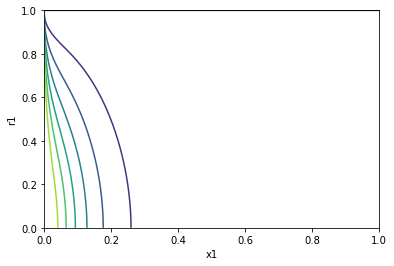

In [21]:
fig, ax1 = plt.subplots()
cset1 = ax1.contour(X1, R1, N)
ax1.set_ylabel("r1")
ax1.set_xlabel("x1")

Now we can calculate the the average particle number flux at each position $x_1$

$$
\begin{split}
n_{av} = 
\frac{\int_0^R \! n_1 \cdot u_1 \cdot r_1 \, \cdot \mathrm{d}r_1}
{\int_0^R \! u_1 \cdot r_1 \, \cdot \mathrm{d}r_1} = f(x_1)
\end{split}
$$


In [22]:
n_av = np.zeros((nx))
n_av[:] = np.sum(u[:] * N[:,:] * (rmax - rmin) * dr, axis=1) / \
            np.sum(u[:] * (rmax - rmin) * dr)

Let's compare our numerical solution with the analytical one.

We can calculate the analytical solution with the following Eigenvectors. Here we use the paper by [Sellars, 
Tribus and Klein 1954](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/7510/bad2050.0001.001.pdf?sequence=5) (see page 8). You can also check for a more "modern" version by Tandon, P. "Extended Graetz Solution for Predicting Nonreacting Vapor Species Concentration Profile and Wall Deposition Rate for Non-Isothermal Laminar Flow through a Pipe", Chemical Engineering Communications, 191 (2) 151-167 [(2004)](https://doi.org/10.1080/00986440490261818).
See also for some more literature below. 

In [23]:
G_lambda2_k = [[7.312, 0.749], [44.62, 0.544], [113.8, 0.463]]
for i in range(3, 20):
    lambda2_k = (4 * i + 8/3)**2
    G_k = 1.01276 * lambda2_k**(-1/6)
    G_lambda2_k.append([lambda2_k, G_k])
G_lambda2_k = np.array(G_lambda2_k)
n_av_analytical = np.zeros((nx))
for i in range(0, nx):
    n_av_analytical[i] = 8 * np.sum(G_lambda2_k[:,1] / G_lambda2_k[:,0] * \
                                    np.exp(- G_lambda2_k[:,0] * x[i]))

Let's plot both solutions (analytical in red; numerical in blue ) and compare...

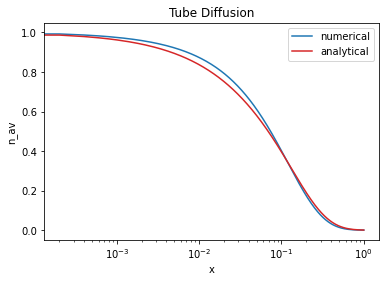

In [24]:
fig, ax2 = plt.subplots()
ax2.semilogx(x, n_av , color = "tab:blue", label="numerical")
ax2.semilogx(x, n_av_analytical , color = "tab:red", label="analytical")
ax2.legend()
ax2.set_title("Tube Diffusion")
ax2.set_ylabel("n_av")
ax2.set_xlabel("x")
plt.show()

Here are some further readings for this topic. If you have difficulties finding these publication, contact me. 

Petter Langtangen, H., Linge, S. (2017). Finite difference computing with PDEs: a modern software approach. Springer Nature.

Shiferaw, A., Mittal, R.C. "Fast Finite Difference Solutions of the Three Dimensional Poisson’s Equation in Cylindrical Coordinates", American Journal of Computational Mathematics, 03 (04) 356-361 (2013). 

Tandon, P. "Extended Graetz Solution for Predicting Nonreacting Vapor Species Concentration Profile and Wall Deposition Rate for Non-Isothermal Laminar Flow through a Pipe", Chemical Engineering Communications, 191 (2) 151-167 (2004). 

Tandon, P., Adewumi, M.A. "Particle deposition from turbulent flow in a pipe", Journal of Aerosol Science, 29 (1-2) 141-156 (1998). 

Swanson, R.C., Turkel, E. (1992). On central-difference and upwind schemes, in Upwind and High-Resolution Schemes, pp167-181, Springer.

Popel, A.S., Gross, J.F. "Mass transfer in the entrance region of a circular tube", International Journal of Heat and Mass Transfer, 21 (8) 1133-1141 (1978). 

Sellars, J.R., Tribus, M., Klein, J. "Heat transfer to laminar flow in a round tube or flat conduit: the Graetz probem extended", Tram. Am. SOC. Mech. Engrs, 78  441 (1956). 

Sleicher Jr, C.A. (1955). Heat transfer in a pipe with turbulent flow and arbitrary wall-temperature distribution.

Sellars, J.R., Tribus, M., Klein, J. (1954). Heat transfer to laminar flow in a round tube or flat conduit: the Graetz probem extended.


